# VSD for Late Show Corpus

This notebook applies the methodology demonstrated in [Story & Bunton (2017)](https://doi.org/10.1121/1.4983342) for calculating density-controlled vowel space area, ideally for measuring vowel space area across task types or mediums. Formant measures are obtained at 5ms intervals of the vowel duration and then normalized. A (200 x 200) grid is generated and for each point on the grid a density value is obtained, equal to the number of formant data points that fall within a 0.05 radius field-of-view around the grid point. A heatmap is created with scaled density values, showing the relative concentrations of vowel productions. A convex hull measure is taken at several density cut-offs.

This sample run-through contains formant measures of Spanish vowels produced by four female speakers of Bay Area Spanish across a word-list elicitation task `wd` and a sociolinguistic interview `int`.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("data/formants.csv")
data.head()

,Video ID,Vowel,Vowel_onset_time,Time_of_formant_measurements,Time_from_vowel_onset,F1,F2,Participant,Task,Word
0,p113_int,o,0.19,0.195,0.005,438.507357,1371.707968,p113,int,no
1,p113_int,o,0.19,0.200,0.010,438.708664,1345.533822,p113,int,no
2,p113_int,o,0.19,0.205,0.015,438.909970,1319.359676,p113,int,no
3,p113_int,o,0.19,0.210,0.020,439.111277,1293.185530,p113,int,no
4,p113_int,o,0.19,0.215,0.025,439.312583,1267.011384,p113,int,no


In [3]:
df = data[data["Participant"]=="p120"].copy()
len(df)

23474

Calculate instances of each vowel.

In [4]:
df.groupby(["Vowel","Task"])["Vowel_onset_time"].nunique()

Vowel  Task
a      int     279
       wd      156
e      int     282
       wd       79
i      int     104
       wd       57
j      int      52
       wd       18
o      int     258
       wd      102
u      int      33
       wd       16
w      int      24
       wd        6
Name: Vowel_onset_time, dtype: int64

### Removal of outliers

The following code is based on the distribution displayed in boxplots. Formants that fall outside the range defined by 75% + (1.5 x IQR) and by 25% - (1.5 x IQR) are treated as ouliers and that formant measure is removed.

In [5]:
# removes productions with outlier formants
# input df has columns `Participant` and `F1` and `F2`

def rem_outliers(df):
    print("Initial length: ", len(df))
    
    # establish 25% and 75% for each formant
    f1_qrts = df.groupby(['Participant', 'Task','Vowel'])["F1"].describe()[['25%', '75%']]
    f2_qrts = df.groupby(['Participant', 'Task','Vowel'])["F2"].describe()[['25%', '75%']]
    
    # find interquartile range for each formant
    f1_qrts['IQR'] = f1_qrts['75%'] - f1_qrts['25%']
    f2_qrts['IQR'] = f2_qrts['75%'] - f2_qrts['25%']
    
    # determine upper limit for each formant
    f1_qrts['upper'] = f1_qrts['75%'] + (1.5 * f1_qrts['IQR'])
    f2_qrts['upper'] = f2_qrts['75%'] + (1.5 * f2_qrts['IQR'])
    
    # determine lower limit for each formant
    f1_qrts['lower'] = f1_qrts['25%'] - (1.5 * f1_qrts['IQR'])
    f2_qrts['lower'] = f2_qrts['25%'] - (1.5 * f2_qrts['IQR'])
    
    # create smaller df with only limits for each formant
    f1_limits = f1_qrts[['upper','lower']]
    f2_limits = f2_qrts[['upper','lower']]
    
    # merge limits into original df
    df = df.merge(f1_limits, left_on = ["Participant", "Task","Vowel"], right_index = True)
    df = df.merge(f2_limits, left_on = ["Participant", "Task","Vowel"], right_index = True, suffixes = ("_f1", "_f2"))
    
    # drop rows with outlier formants
    df = df[(df["F1"] > df["lower_f1"]) & (df["F1"] < df["upper_f1"])]
    df = df[(df["F2"] > df["lower_f2"]) & (df["F2"] < df["upper_f2"])]

    print("Final length: ", len(df))
    return df

In [6]:
df = rem_outliers(df)

Initial length:  23474
Final length:  22536


Normalize the F1 and F2 measures so that the median for each axis is at (0,0) and so that minima are -1 and the maxima are +1 (Lobanov Normalization). We will call the resulting new columns `F1_vsd` and `F2_vsd`.

In [7]:
import numpy as np

medians = df.groupby(["Task"])[["F1", "F2"]].median()
df = df.merge(medians, left_on = ["Task"], right_index = True, suffixes = ("","_med"))
df["F1_vsd"] = (df["F1"]-df["F1_med"])/df["F1_med"]
df["F2_vsd"] = (df["F2"]-df["F2_med"])/df["F2_med"]

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
# divide data set across task for plotting
df_wd = df[df["Task"]=="wd"].copy()
df_int = df[df["Task"]=="int"].copy()

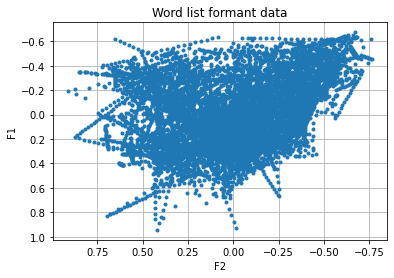

In [10]:
fig, ax = plt.subplots()
ax.plot(df_wd["F2_vsd"], df_wd["F1_vsd"], '.')

# invert x- and y- axes
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

ax.set(xlabel='F2', ylabel='F1',
       title='Word list formant data')
ax.grid()

plt.show()

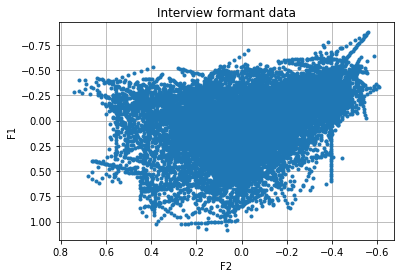

In [11]:
fig, ax = plt.subplots()
ax.plot(df_int["F2_vsd"], df_int["F1_vsd"], '.')

# invert x- and y- axes
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

ax.set(xlabel='F2', ylabel='F1',
       title='Interview formant data')
ax.grid()

plt.show()

## Second step: create grid with discretized dimensions

In [12]:
xvalues = np.flip(np.arange(-1., 1.01, 0.01))
yvalues = np.arange(-1., 1.01, 0.01)

grid = [(round(x, 2), round(y,2)) for x in xvalues for y in yvalues]
len(grid)

40401

## Third step: calculate number of data points that fall within 0.05 radius from each point above

In [13]:
from scipy.spatial import distance

def density(grid, df):
    density = {}
    for c in grid:
        # define x and y coordinate
        x = c[0]
        y = c[1]
    
        # define max and min coordinates that form a square of length 0.1 around the coordinate
        x_max = x + 0.05
        x_min = x - 0.05
        y_max = y + 0.05
        y_min = y - 0.05
    
        # pull a subset of data that fall within the box
        opts = df[(df["F2_vsd"] <= x_max) &
               (df["F2_vsd"] >= x_min) &
               (df["F1_vsd"] <= y_max) &
               (df["F1_vsd"] >= y_min)].copy()
        opts_list = list(zip(opts["F2_vsd"], opts["F1_vsd"]))
    
        # define density for this point
        dens = 0
    
        for o in opts_list:
            # define x and y coordinate of each point in my data
            o_x = o[0]
            o_y = o[1]
        
            # calculate distance to grid point
            dist = distance.euclidean([x, y], [o_x, o_y])
        
            if dist <= 0.05:
                dens += 1
        
        density[c] = dens
    
    # convert to df
    density_df = pd.DataFrame(density.items())
    density_df = density_df.rename(columns = {0: "coord", 1:"density"})
    
    # make grid into df
    grid_df = pd.DataFrame(grid, columns=["x", "y"])
    grid_df["coord"] = list(zip(grid_df["x"], grid_df["y"]))
    
    # join df and grid_df
    grid_df = grid_df.join(density_df.set_index('coord'), on="coord")
    
    return grid_df 

In [14]:
grid_wd_df = density(grid, df_wd)

In [15]:
grid_int_df = density(grid, df_int)

## Step four: normalize density measures

Scaled so that density measures range from 0 to 1.

In [16]:
grid_wd_df["density_norm"] = grid_wd_df["density"].apply(lambda x: x/grid_wd_df["density"].max())
grid_int_df["density_norm"] = grid_int_df["density"].apply(lambda x: x/grid_int_df["density"].max())

## Step five: plot in 3D space

In [17]:
import seaborn as sns

In [18]:
grid_wd_df_pivot = pd.pivot_table(grid_wd_df,
                    index='y',
                    values='density_norm',
                    columns='x')

# reindex column order to reflect standard representation of vowel formant space
columns = grid_wd_df_pivot.columns.tolist()
columns = columns[::-1]
grid_wd_df_pivot = grid_wd_df_pivot[columns]

grid_wd_df_pivot.head()

x,1.00,0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,...,-0.91,-0.92,-0.93,-0.94,-0.95,-0.96,-0.97,-0.98,-0.99,-1.00
y,,,,,,,,,,,,,,,,,,,,,
-1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
grid_int_df_pivot = pd.pivot_table(grid_int_df,
                    index='y',
                    values='density_norm',
                    columns='x')

# reindex column order to reflect standard representation of vowel formant space
columns = grid_int_df_pivot.columns.tolist()
columns = columns[::-1]
grid_int_df_pivot = grid_int_df_pivot[columns]

grid_int_df_pivot.head()

x,1.00,0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,...,-0.91,-0.92,-0.93,-0.94,-0.95,-0.96,-0.97,-0.98,-0.99,-1.00
y,,,,,,,,,,,,,,,,,,,,,
-1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


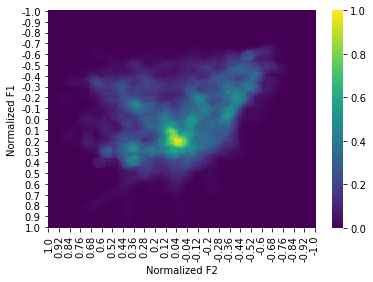

In [20]:
midpoint_wd = (grid_wd_df_pivot.values.max() - grid_wd_df_pivot.values.min()) / 2
sns.heatmap(grid_wd_df_pivot, cmap="viridis", center=midpoint_wd)
plt.xlabel('Normalized F2')
plt.ylabel('Normalized F1')
plt.show()

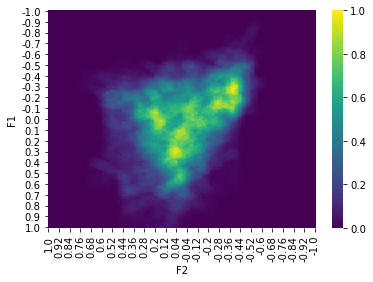

In [21]:
midpoint_int = (grid_int_df_pivot.values.max() - grid_int_df_pivot.values.min()) / 2
sns.heatmap(grid_int_df_pivot, cmap="viridis", center=midpoint_int)
plt.xlabel('F2')
plt.ylabel('F1')
plt.show()

Based on the plots above, this speaker's production are more centralized in the word list elicitation task than the sociolinguistic interview. This could possibly be attributed to all the elicitations being single utterances, rather than being placed in carrier phrases.

## Step six: calculate convexhull area at density cutoff of 0.3, 0.25, 0.2, 0.15 and 0.1

In [22]:
from scipy.spatial import ConvexHull

In [23]:
# pull out coordinates with various density cutoffs

cutoffs = [0.10, 0.15, 0.20, 0.25, 0.3]

areas_list = []

for c in cutoffs:
    grid_wd_density = grid_wd_df[grid_wd_df["density_norm"] >= c].copy()
    grid_int_density = grid_int_df[grid_int_df["density_norm"] >= c].copy()
    
    points_tuples_wd = list(grid_wd_density["coord"])
    points_tuples_int = list(grid_int_density["coord"])
    
    points_wd = [list(k) for k in points_tuples_wd]
    points_int = [list(k) for k in points_tuples_int]
    
    hull_wd = ConvexHull(points_wd)
    hull_int = ConvexHull(points_int)
    
    area_wd = hull_wd.area
    area_int = hull_int.area

    areas = {"Task": ["wd", "int"], "Area": [area_wd, area_int], "Cutoff": c}
    areas_list.append(areas)

In [24]:
areas_list

[{'Task': ['wd', 'int'],
  'Area': [4.213787630779314, 4.2457180195499795],
  'Cutoff': 0.1},
 {'Task': ['wd', 'int'],
  'Area': [3.9683116728267147, 4.058396770058407],
  'Cutoff': 0.15},
 {'Task': ['wd', 'int'],
  'Area': [3.803097399277268, 3.865271710852511],
  'Cutoff': 0.2},
 {'Task': ['wd', 'int'],
  'Area': [3.494722149813321, 3.6235678350729787],
  'Cutoff': 0.25},
 {'Task': ['wd', 'int'],
  'Area': [3.1765370431829236, 3.4100252925458943],
  'Cutoff': 0.3}]

In [25]:
areas_df = pd.DataFrame(areas_list)
areas_df

,Task,Area,Cutoff
0,"[wd, int]","[4.213787630779314, 4.2457180195499795]",0.10
1,"[wd, int]","[3.9683116728267147, 4.058396770058407]",0.15
2,"[wd, int]","[3.803097399277268, 3.865271710852511]",0.20
3,"[wd, int]","[3.494722149813321, 3.6235678350729787]",0.25
4,"[wd, int]","[3.1765370431829236, 3.4100252925458943]",0.30


In [26]:
areas_df_task = areas_df.explode('Task')
areas_df_task = areas_df_task.drop(["Area", "Cutoff"], axis = 1)
areas_df_area = areas_df.explode('Area')
areas_df_area = areas_df_area.drop("Task", axis = 1)
areas_df = pd.concat([areas_df_task, areas_df_area], axis = 1)
areas_df

,Task,Area,Cutoff
0,wd,4.213788,0.10
0,int,4.245718,0.10
1,wd,3.968312,0.15
1,int,4.058397,0.15
2,wd,3.803097,0.20
2,int,3.865272,0.20
3,wd,3.494722,0.25
3,int,3.623568,0.25
4,wd,3.176537,0.30
4,int,3.410025,0.30


In [27]:
areas_df.to_csv("data/hull_areas_all.csv", index = False)

## Define function to calculate vowel space density

Synthesize code chunks above into one function that will take an input df with multiple speakers in two task types and will return a dataframe with columns: `Participant`, `Area`, `Cutoff`, and `Task`, where `Task` will have the two levels `wd` and `int`.

In [28]:
def vsd(df):
    import pandas as pd
    import numpy as np
    from scipy.spatial import ConvexHull
    from scipy.spatial import distance
    
    # get lists of participants in dataset
    parts = list(df['Participant'].unique())
        
    # define empty list to fill with participant values in form of dataframes
    areas_all = []
    
    # define necessary functions and global variables
    ################################################################################
   
    def rem_outliers(df):
        print("Removal of outliers:")
        print("Initial length: ", len(df))
    
        # establish 25% and 75% for each formant
        f1_qrts = df.groupby(['Participant','Task','Vowel'])["F1"].describe()[['25%', '75%']]
        f2_qrts = df.groupby(['Participant','Task','Vowel'])["F2"].describe()[['25%', '75%']]
    
        # find interquartile range for each formant
        f1_qrts['IQR'] = f1_qrts['75%'] - f1_qrts['25%']
        f2_qrts['IQR'] = f2_qrts['75%'] - f2_qrts['25%']
    
        # determine upper limit for each formant
        f1_qrts['upper'] = f1_qrts['75%'] + (1.5 * f1_qrts['IQR'])
        f2_qrts['upper'] = f2_qrts['75%'] + (1.5 * f2_qrts['IQR'])
    
        # determine lower limit for each formant
        f1_qrts['lower'] = f1_qrts['25%'] - (1.5 * f1_qrts['IQR'])
        f2_qrts['lower'] = f2_qrts['25%'] - (1.5 * f2_qrts['IQR'])
    
        # create smaller df with only limits for each formant
        f1_limits = f1_qrts[['upper','lower']]
        f2_limits = f2_qrts[['upper','lower']]
    
        # merge limits into original df
        df = df.merge(f1_limits, left_on = ["Participant", 'Task', "Vowel"], right_index = True)
        df = df.merge(f2_limits, left_on = ["Participant", "Task", "Vowel"], right_index = True, suffixes = ("_f1", "_f2"))
    
        # drop rows with outlier formants
        df = df[(df["F1"] > df["lower_f1"]) & (df["F1"] < df["upper_f1"])]
        df = df[(df["F2"] > df["lower_f2"]) & (df["F2"] < df["upper_f2"])]

        print("Final length: ", len(df))
        return df
    
    ####################################################################################
    # define function to scale all formant measures
    def scale_formants(df):
        medians = df.groupby(["Participant","Task"])[["F1", "F2"]].median()

        df = df.merge(medians, left_on = ["Participant","Task"], right_index = True, suffixes = ("","_med"))
        df["F1_vsd"] = (df["F1"]-df["F1_med"])/df["F1_med"]
        df["F2_vsd"] = (df["F2"]-df["F2_med"])/df["F2_med"]
        
        print("Formant data scaled")
        return df 
    
    ####################################################################################
    
    # define variable `grid`
    xvalues = np.flip(np.arange(-1., 1.01, 0.01))
    yvalues = np.arange(-1., 1.01, 0.01)

    grid = [(round(x, 2), round(y,2)) for x in xvalues for y in yvalues]
      
    #####################################################################################
    
    # define function get_density
    def density(grid, df):
        density_dict = {}
        for c in grid:
            # define x and y coordinate
            x = c[0]
            y = c[1]
    
            # define max and min coordinates that form a square of length 0.1 around the coordinate
            x_max = x + 0.05
            x_min = x - 0.05
            y_max = y + 0.05
            y_min = y - 0.05
    
            # pull a subset of data that fall within the box
            opts = df[(df["F2_vsd"] <= x_max) &
               (df["F2_vsd"] >= x_min) &
               (df["F1_vsd"] <= y_max) &
               (df["F1_vsd"] >= y_min)].copy()
            opts_list = list(zip(opts["F2_vsd"], opts["F1_vsd"]))
    
             # define density for this point
            dens = 0
    
            for o in opts_list:
                # define x and y coordinate of each point in my data
                o_x = o[0]
                o_y = o[1]
        
                # calculate distance to grid point
                dist = distance.euclidean([x, y], [o_x, o_y])
        
                if dist <= 0.05:
                    dens += 1
        
            density_dict[c] = dens
    
        # convert to df
        density_df = pd.DataFrame(density_dict.items())
        density_df = density_df.rename(columns = {0: "coord", 1:"density"})
    
        # make grid into df
        grid_df = pd.DataFrame(grid, columns=["x", "y"])
        grid_df["coord"] = list(zip(grid_df["x"], grid_df["y"]))
    
        # join df and grid_df
        grid_df = grid_df.join(density_df.set_index('coord'), on="coord")
              
        return grid_df
    
    ##################################################################################
    # remove outliers by participant, by task, by vowel
    df = rem_outliers(df)
    
    # Lobanov normalization of formants, by participant by task
    df = scale_formants(df)
    
    for i in parts:
        print("\n",i)
        
        # get subset of data for speaker across modality
        df_wd = df[(df["Participant"]==i) & (df["Task"]== "wd")].copy()
        df_int = df[(df["Participant"]==i) & (df["Task"]== "int")].copy()  
           
        # get density for each point across the modalities
        grid_wd_df = density(grid, df_wd)
        print("Densities calculated for wordlist")
        grid_int_df = density(grid, df_int)
        print("Densities calculated for interview")
              
        # scale density measures
        grid_wd_df["density_norm"] = grid_wd_df["density"].apply(lambda x: x/grid_wd_df["density"].max())
        grid_int_df["density_norm"] = grid_int_df["density"].apply(lambda x: x/grid_int_df["density"].max())
        
        # pull out coordinates at various density cutoffs and get areas
        cutoffs = [0.10, 0.15, 0.20, 0.25, 0.3]

        areas_list = []

        for c in cutoffs:
            grid_wd_density = grid_wd_df[grid_wd_df["density_norm"] >= c].copy()
            grid_int_density = grid_int_df[grid_int_df["density_norm"] >= c].copy()
    
            points_tuples_wd = list(grid_wd_density["coord"])
            points_tuples_int = list(grid_int_density["coord"])
    
            points_wd = [list(k) for k in points_tuples_wd]
            points_int = [list(k) for k in points_tuples_int]
    
            hull_wd = ConvexHull(points_wd)
            hull_int = ConvexHull(points_int)
    
            area_wd = hull_wd.area
            area_int = hull_int.area

            areas = {"Task": ["wd", "int"], "Area": [area_wd, area_int], "Cutoff": c}
            areas_list.append(areas)
            
        # to show progress while running, print areas at density cutoff of 0.25
        print("Wordlist, Interview areas at 0.25 cutoff are: ", areas_list[3]["Area"])
        
        # generate dataframe for this participant and reformat
        areas_df = pd.DataFrame(areas_list)
        areas_df_task = areas_df.explode('Task')
        areas_df_task = areas_df_task.drop(["Area", "Cutoff"], axis = 1)
        areas_df_area = areas_df.explode('Area')
        areas_df_area = areas_df_area.drop("Task", axis = 1)
        areas_df = pd.concat([areas_df_task, areas_df_area], axis = 1)
        areas_df["Participant"] = i

        # append dataframe to list of dataframes
        areas_all.append(areas_df)
 
    # return dataframe of areas
    areas_to_return = pd.concat(areas_all)
    
    return areas_to_return

In [29]:
areas = vsd(data)

Removal of outliers:
Initial length:  115522
Final length:  107752
Formant data scaled

 p113
Densities calculated for wordlist
Densities calculated for interview
Wordlist, Interview areas at 0.25 cutoff are:  [2.382854645004531, 2.965274371293386]

 p115
Densities calculated for wordlist
Densities calculated for interview
Wordlist, Interview areas at 0.25 cutoff are:  [2.3919308386317706, 3.0992885104900285]

 p120
Densities calculated for wordlist
Densities calculated for interview
Wordlist, Interview areas at 0.25 cutoff are:  [3.494722149813321, 3.6235678350729787]

 p124
Densities calculated for wordlist
Densities calculated for interview
Wordlist, Interview areas at 0.25 cutoff are:  [1.9500131176647173, 2.8610137391208]


In [30]:
areas.head()

,Task,Area,Cutoff,Participant
0,wd,3.391166,0.10,p113
0,int,3.917149,0.10,p113
1,wd,3.0438,0.15,p113
1,int,3.61933,0.15,p113
2,wd,2.479183,0.20,p113


In [31]:
len(areas)

40

In [32]:
areas.to_csv("areas_all.csv", index = False)